In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob
from deep_translator import GoogleTranslator
import detectlanguage

User_reviews --> Análisis de sentimiento

In [14]:
user_reviews = pd.read_csv('../user_reviews.csv')

In [4]:
# Ejemplo de review
user_reviews.loc[0, "review"]

"Simple yet with great replayability. In my opinion does 'zombie' hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth 'zombie' splattering fun for the whole family. Amazed this sort of FPS is so rare."

In [140]:
for indice, review in enumerate(user_reviews["review"]):
    review_procesada = TextBlob(review)
    user_reviews.loc[indice, "Polarity"] = review_procesada.polarity
    user_reviews.loc[indice, "Subjectivity"] = review_procesada.subjectivity

In [141]:
user_reviews.describe()

,item_id,Polarity,Subjectivity
count,59305.000000,59305.000000,59305.000000
mean,169935.176511,0.114592,0.422944
std,132029.464174,0.294695,0.268370
min,10.000000,-1.000000,0.000000
25%,8930.000000,0.000000,0.275000
50%,218230.000000,0.058763,0.475000
75%,261760.000000,0.250000,0.592857
max,527340.000000,1.000000,1.000000


In [161]:
user_reviews[(user_reviews["Polarity"] >= -1) & (user_reviews["Polarity"] < -0.4)]["recommend"]

47        True
62       False
132      False
162       True
253       True
         ...  
59265     True
59268    False
59281     True
59282     True
59284    False
Name: recommend, Length: 1574, dtype: bool

In [162]:
# Defino una función para asignar valores a una columna 'sentiment_analysis'
def assign_sentiment(polarity):
    if -1 <= polarity <= -0.4:
        return 0
    elif -0.4 < polarity <= 0.05:
        return 1
    elif 0.05 < polarity <= 1:
        return 2
    else:
        return None  # Manejo de valores fuera de los rangos especificados

# Aplica la función a la columna 'Polarity' y crea la nueva columna 'sentiment_analysis'
user_reviews['sentiment_analysis'] = user_reviews['Polarity'].apply(assign_sentiment)

In [164]:
# 2 es positivo, 1 neutral y 0 negativo
user_reviews["sentiment_analysis"].value_counts()

sentiment_analysis
2    30166
1    25881
0     3258
Name: count, dtype: int64

In [166]:
# Borramos las columnas "Polarity" y "Subjectivity" y también "reviews", porque ya no la necesitamos
user_reviews = user_reviews.drop(columns = ["Polarity", "Subjectivity", "review"])


In [168]:
user_reviews.isna().sum()

user_id                   0
user_url                  0
posted                10119
item_id                   0
recommend                 0
review                    0
sentiment_analysis        0
dtype: int64

In [ ]:
# Exportamos user_reviews modificado
user_reviews.to_csv('../user_reviews.csv', index = False)

##### Games

In [204]:
# Cargamos el dataframe de games limpio, luego del ETL
games = pd.read_csv("../games.csv")
games['release_date'] = pd.to_datetime(games['release_date'])

In [205]:
# Eliminamos las columnas multilabel sin el procesamiento, que las traemos del ETL
games = games.drop(columns = ["genres", "tags", "specs"])

In [206]:
games.dtypes

publisher                                 object
title                                     object
release_date                      datetime64[ns]
price                                    float64
early_access                                bool
                                       ...      
specs_Steam Trading Cards                  int64
specs_Steam Turn Notifications             int64
specs_Steam Workshop                       int64
specs_SteamVR Collectibles                 int64
specs_Valve Anti-Cheat enabled             int64
Length: 400, dtype: object

In [182]:
# Analizamos la fecha de estreno del juego y el precio
games[["release_date", "price"]].describe()

,release_date,price
count,30085,30085.000000
mean,2014-02-21 06:47:16.682732544,8.728522
min,1900-01-01 00:00:00,0.000000
25%,2014-09-05 00:00:00,2.990000
50%,2016-04-07 00:00:00,4.990000
75%,2017-04-12 00:00:00,9.990000
max,2021-12-31 00:00:00,995.000000
std,NaN,16.275861


La mediana de fecha está alrededor del 2016 y el último estreno en 2021, para tener una noción de los valores. Los del 01-01-1900 son los valores de fecha desconocida, se hizo asi para que la columna pueda ser datetime.

El precio es poco variable pero hay outliers aparentemente. Vamos a analizarlo.

<Axes: xlabel='price'>

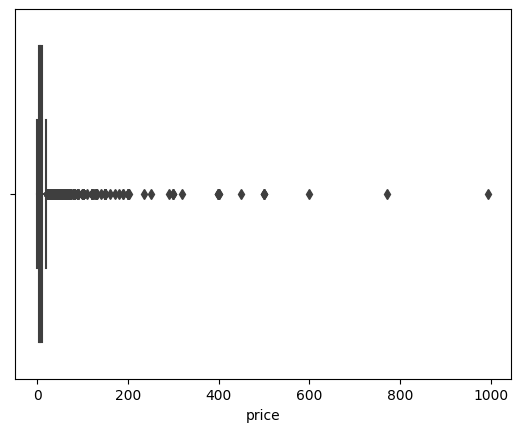

In [7]:
# Precio
sns.boxplot(data = games, x = "price")

In [183]:
# Analizamos aquellos precios mayores a 300 dolares
games.loc[games["price"] >= 300, (games.loc[games["price"] > 300]).ne(0).any()]

,publisher,title,release_date,price,id,developer,genres_Animation &amp; Modeling,genres_Audio Production,genres_Design &amp; Illustration,genres_Education,...,specs_Cross-Platform Multiplayer,specs_Downloadable Content,specs_In-App Purchases,specs_MMO,specs_Multi-player,specs_Online Multi-Player,specs_Sin Categoria,specs_Single-player,specs_Steam Achievements,specs_Steam Trading Cards
2378,Aerosoft GmbH,X-Plane 10 Global - 64 Bit,2014-07-14,771.71,292180,Laminar Research,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
8648,YoYo Games Ltd.,GameMaker Studio 2 Mobile,2017-03-08,399.99,585620,YoYo Games Ltd.,1,0,1,1,...,0,0,1,0,0,0,0,0,0,0
8649,YoYo Games Ltd.,GameMaker Studio 2 UWP,2017-03-08,399.99,585610,YoYo Games Ltd.,1,0,1,1,...,0,0,1,0,0,0,0,0,0,0
8947,MAGIX Software GmbH,MAGIX Video Pro X8 Steam Edition,2017-04-11,399.00,598860,MAGIX Software GmbH,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
11043,CLO Virtual Fashion,Marvelous Designer 7 For Steam,2017-09-28,320.00,707410,CLO Virtual Fashion,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
11364,"Strata Mixed Reality, Inc.",Strata Spaces VR – Professional Edition Upgrade,2017-10-26,995.00,719000,"Strata Mixed Reality, Inc.",1,0,1,0,...,0,1,0,0,0,0,0,0,1,1
12862,MAGIX Software GmbH,MAGIX Video Pro X9 Steam Edition,2017-11-28,399.00,750840,MAGIX Software GmbH,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
13356,RUHRSOURCE GmbH,CUR3D Maker Edition - Permission for commercia...,2017-11-06,499.99,691560,RUHRSOURCE GmbH,1,0,1,1,...,0,1,0,0,0,0,0,0,0,0
14744,MAGIX Software GmbH,VEGAS Pro 15 Edit Steam Edition,2017-09-05,399.00,689790,MAGIX Software GmbH,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
16475,CCP,EVE Online: 15400 PLEX,2017-05-09,499.99,629796,CCP,0,0,0,0,...,0,1,0,1,0,1,0,0,0,1


Analizando estos juegos, vemos que muchos son para la edición de fotos, videos, diseño de indumentaria, un simulador de vuelo. Son profesionales aparentemente, de ahí su precio que es correcto

##### Columnas genres, tags y specs

Eran columna multilabel por lo que las preprocesamos en ETL. Vamos a dejar asentado cuantas categorias tiene cada una (las usaremos para el modelo de ML)

In [184]:
# 23 columnas de género del juego
columnas_generos = [col for col in games.columns if col.startswith('genres_')]
len(columnas_generos)

23

In [185]:
# 32 columnas de especificaciones
columnas_specs = [col for col in games.columns if col.startswith('specs_')]
len(columnas_specs)

32

In [186]:
# 338 columnas de tags
columnas_tags = [col for col in games.columns if col.startswith('tags_')]
len(columnas_tags)

338

In [187]:
# Las columnas de tags son muchas, vamos a dejar solo las 50 más frecuentes
suma_por_columna = games[columnas_tags].sum()
suma_por_columna = suma_por_columna.sort_values(ascending = False)
# Selecciona las 50 primeras columnas de la Serie ordenada
columnas_top_50_tags = suma_por_columna[:50].index
# Pasamos a un df auxiliar
top_50_tags = games[columnas_top_50_tags]
# Eliminamos todas y recuperamos con el auxiliar el top 50
games = games.drop(columns = columnas_tags)
games = pd.concat([games, top_50_tags], axis = 1)

In [188]:
# Ahora games tiene un tamaño de 112 columnas, consideramos algo acorde.
games.shape

(30085, 112)

##### publisher y developer

In [189]:
# Categorias de publicadores
len(games["publisher"].unique())

8238

In [190]:
# Inicializar el OneHotEncoder
encoder = OneHotEncoder(sparse = False)
binarizado = encoder.fit_transform(games[['publisher']])
publisher = pd.DataFrame(binarizado, columns = encoder.get_feature_names_out(['publisher']))

c:\Users\Mauricio Figueroa\.virtualenvs\mlops-env-j3OugPxT\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [191]:
# Si dejamos 30 "publisher", vamos a representar poco más de 10000 juegos frente a 80000.
publisher.sum().sort_values(ascending = False).head(30).sum()

10641.0

In [192]:
# Hacemos el top 30
columnas_quedan = publisher.sum().sort_values(ascending = False).head(30).index.tolist()
publisher = publisher[columnas_quedan]

In [207]:
# Concatenamos con nuestro dataframe
games = pd.concat([games, publisher], axis = 1)

In [208]:
# Categorias de developer
len(games["developer"].unique())

10993

In [195]:
# Inicializar el OneHotEncoder
encoder = OneHotEncoder(sparse = False)
binarizado = encoder.fit_transform(games[['developer']])
developer = pd.DataFrame(binarizado, columns = encoder.get_feature_names_out(['developer']))

c:\Users\Mauricio Figueroa\.virtualenvs\mlops-env-j3OugPxT\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [196]:
# Si dejamos 50 "developer" vamos a representar poco más de 6000 juegos frente a 80000.
developer.sum().sort_values(ascending = False).head(50).sum()

6480.0

In [197]:
columnas_quedan = developer.sum().sort_values(ascending = False).head(50).index.tolist()
developer = developer[columnas_quedan]

In [209]:
pd.concat([games, developer], axis = 1)

,publisher,title,release_date,price,early_access,id,developer,genres_Accounting,genres_Action,genres_Adventure,...,developer_Sports Interactive,developer_Telltale Games,developer_Overhead Games,developer_TAMSOFT,developer_Aldorlea Games,developer_Warfare Studios,developer_Idea Factory,developer_Humongous Entertainment,"developer_Rainbow Studios,THQ Nordic","developer_CAPCOM Co., Ltd."
0,Kotoshiro,Lost Summoner Kitty,2018-01-04,4.99,False,761140,Kotoshiro,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Making Fun, Inc.",Ironbound,2018-01-04,0.00,False,643980,Secret Level SRL,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Poolians.com,Real Pool 3D - Poolians,2017-07-24,0.00,False,670290,Poolians.com,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,彼岸领域,弹炸人2222,2017-12-07,0.99,False,767400,彼岸领域,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Trickjump Games Ltd,Battle Royale Trainer,2018-01-04,3.99,False,772540,Trickjump Games Ltd,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30080,Bidoniera Games,Kebab it Up!,2018-01-04,1.99,False,745400,Bidoniera Games,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30081,Ghost_RUS Games,Colony On Mars,2018-01-04,1.99,False,773640,"Nikita ""Ghost_RUS""",0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30082,Sacada,LOGistICAL: South Africa,2018-01-04,4.99,False,733530,Sacada,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30083,Laush Studio,Russian Roads,2018-01-04,1.99,False,610660,Laush Dmitriy Sergeevich,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [210]:
# Podemos borrar las columnas publisher, developer y tambien title, dejamos para el modelo de ML
games = games.drop(columns = ["publisher", "title", "developer"])

In [212]:
games.head(2)

,release_date,price,early_access,id,genres_Accounting,genres_Action,genres_Adventure,genres_Animation &amp; Modeling,genres_Audio Production,genres_Casual,...,publisher_Choice of Games,publisher_Aerosoft GmbH,publisher_1C Company,publisher_Warner Bros. Interactive Entertainment,publisher_Devolver Digital,publisher_Wizards of the Coast LLC,publisher_505 Games,publisher_Sekai Project,publisher_AGM PLAYISM,publisher_Focus Home Interactive
0,2018-01-04,4.99,False,761140,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-01-04,0.00,False,643980,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [201]:
# Hay algunas columnas como float, corregimos
columnas_convertir = games.columns[2:]
for columna in columnas_convertir:
    games[columna] = games[columna].astype(int)

##### Columna fecha de estreno

In [213]:
# Tomamos solo el año de estreno, para poder pasarlo al modelo de ML
games['release_date'] = games['release_date'].dt.year

##### Standard Scaler para columna price y año de estreno

In [240]:
# Hacemos el Standard Scaler
scaler = StandardScaler()
normalizadas = scaler.fit_transform(games[['release_date', 'price']])
games[['release_date', 'price']] = pd.DataFrame(normalizadas)

In [241]:
games.describe()

,release_date,price,id,genres_Accounting,genres_Action,genres_Adventure,genres_Animation &amp; Modeling,genres_Audio Production,genres_Casual,genres_Design &amp; Illustration,...,publisher_Aerosoft GmbH,publisher_1C Company,publisher_Warner Bros. Interactive Entertainment,publisher_Devolver Digital,publisher_Wizards of the Coast LLC,publisher_505 Games,publisher_Sekai Project,publisher_AGM PLAYISM,publisher_Focus Home Interactive,recom_positivas
count,3.008500e+04,3.008500e+04,3.008500e+04,30085.000000,30085.000000,30085.000000,30085.000000,30085.000000,30085.000000,30085.000000,...,30085.000000,30085.000000,30085.000000,30085.000000,30085.000000,30085.000000,30085.000000,30085.000000,30085.000000,3.008500e+04
mean,3.295161e-15,-4.959747e-17,4.439946e+05,0.000233,0.376267,0.273990,0.006083,0.003091,0.275287,0.015290,...,0.003191,0.002992,0.002759,0.002726,0.002726,0.002726,0.002692,0.002692,0.002692,5.668282e-18
std,1.000017e+00,1.000017e+00,1.842385e+05,0.015252,0.484456,0.446011,0.077756,0.055514,0.446666,0.122706,...,0.056399,0.054614,0.052453,0.052137,0.052137,0.052137,0.051819,0.051819,0.051819,1.000017e+00
min,-9.483904e+00,-5.362953e-01,1.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.480613e-02
25%,3.310999e-02,-3.525846e-01,3.218300e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.480613e-02
50%,2.000752e-01,-2.297012e-01,4.383000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.480613e-02
75%,2.835577e-01,7.750737e-02,5.889700e+05,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.480613e-02
max,6.174881e-01,6.059820e+01,2.028850e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.074537e+02


##### early_access

In [242]:
# Pasamos esta columna de True/False a 1/0
games["early_access"] = games["early_access"].astype(int)

In [243]:
# Eliminamos la columna "id", que no es necesaria para el modelo de ML
games = games.drop(columns = ["id"])

In [244]:
# Exportamos para ser consumidas por el modelo de ML
games.to_csv('../games_ml.csv', index = False)

In [252]:
# Ahora traemos el df original games, luego del ETL y dejamos solo las columnas que necesitamos
games = pd.read_csv("../games.csv")
games = games[["id", "title", "release_date"]]

In [254]:
# Exportamos para ser consumidas por la API
games.to_csv('../games.csv', index = False)